# Image Captioning
## 2023-04-26
[Connecting Jupyter Lab to GitHub](https://stackoverflow.com/questions/68775869/message-support-for-password-authentication-was-removed-please-use-a-personal)

* To create your own dataset, follow tutorial [here](https://huggingface.co/docs/datasets/create_dataset)
* Converting image to base64 [link](https://stackoverflow.com/questions/31826335/how-to-convert-pil-image-image-object-to-base64-string)

In [ ]:
!pip install transformers datasets evaluate jiwer ipywidgets wandb

In [ ]:
# importing dependencies
import transformers
from datasets import load_dataset
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer, EncoderDecoderModel
from evaluate import load
import torch
from PIL import Image
import requests

In [3]:
# loading dataset
ds = load_dataset("lambdalabs/pokemon-blip-captions")

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

In [5]:
train_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 749
})

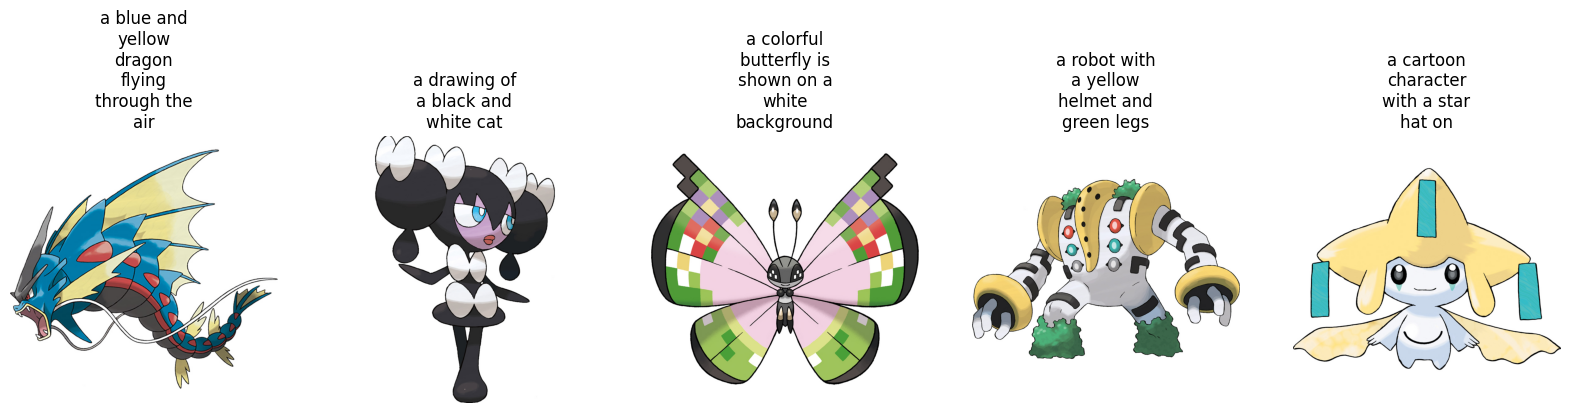

In [7]:
# plotting our data

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")
        
sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [8]:
MODEL_NAME = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(MODEL_NAME)

In [10]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [11]:
wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [12]:
# loading model

model = A.from_pretrained(MODEL_NAME)

In [13]:
# train the model

model_name = MODEL_NAME.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=10,
    fp16=True,
    disable_tqdm=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
wandb: Currently logged in as: vinted_dqmis. Use `wandb login --relogin` to force relogin
